<a href="https://colab.research.google.com/github/TanmayWINTR/OilSeepDetection/blob/main/OilSeepDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oil Seep Detection

**Check GPU Availability**

To optimise TensorFlow operations, it's crucial to determine if a GPU is available. This segment verifies the presence of a GPU, enhancing computational efficiency during model training.

In [ ]:
# Import necessary libraries
import os
import tarfile
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Check for GPU availability
if tf.test.gpu_device_name():
    print('GPU is available')
else:
    print('No GPU detected')


GPU is available


**Upload and Extract Dataset**

This part facilitates the upload and extraction of a tar.gz file. It ensures that the dataset is readily accessible for subsequent processing steps.

In [ ]:
# Upload the tar.gz file to Colab
from google.colab import files
uploaded = files.upload()

# Extract the tar.gz file
tar_file = 'seep_detection.tar.gz'

# Extract the tar.gz file
if tarfile.is_tarfile(tar_file):
    with tarfile.open(tar_file, 'r:gz') as tar:
        tar.extractall()
        print(f'Extracted {tar_file}')
else:
    print(f'{tar_file} is not a tar file.')

# Paths to the data
train_images_path = './seep_detection/train_images_256'
mask_images_path = './seep_detection/train_masks_256'
tif_files = [f for f in os.listdir(train_images_path) if f.endswith('.tif')]

# Create a list of image and mask paths
image_paths = [os.path.join(train_images_path, f) for f in tif_files]
mask_paths = [os.path.join(mask_images_path, f) for f in tif_files]



Saving seep_detection.tar.gz to seep_detection.tar.gz
Extracted seep_detection.tar.gz


**Visualise Original Image and Mask**

Here, we display an example of an original image alongside its corresponding mask. This visualisation helps in comprehending the structure and content of the dataset.

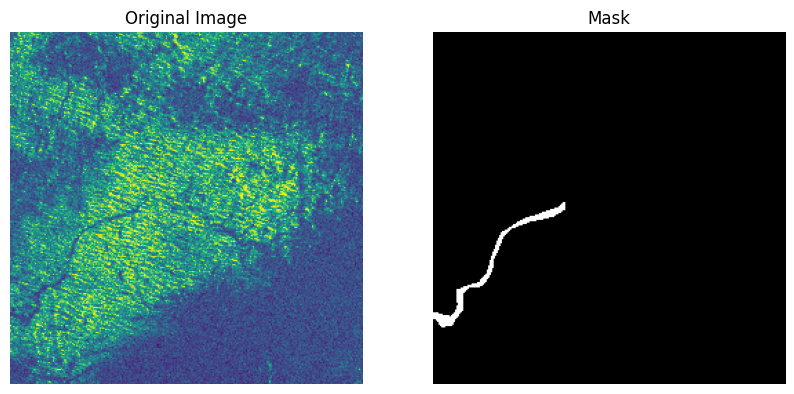

In [ ]:
# Open and display one of the TIFF files
tif_file = os.path.join(train_images_path, tif_files[0])
image = Image.open(tif_file)

# Load and display corresponding mask
mask_file = os.path.join(mask_images_path, tif_files[0])
mask = Image.open(mask_file)

# Display the image
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

In [ ]:
image.mode

'I;16'

In [ ]:
mask.mode

'L'

**Load and Preprocess Images and Masks**

In this section, images and masks are loaded from the dataset. They are then preprocessed by normalizing the images and ensuring the masks are correctly formatted. This step is fundamental to prepare the data for further use in training.

In [ ]:
import numpy as np
# Function to load and preprocess images and masks
def load_and_preprocess_image(image_path, mask_path):
    # Load image
    image = Image.open(image_path)
    print(f"Original image mode: {image.mode}")

    # Convert 16-bit image to 8-bit by dividing by 256 if necessary
    if image.mode == 'I;16':
        image = np.array(image, dtype=np.uint16) // 256
        image = Image.fromarray(image.astype(np.uint8), mode='L')

    # Convert to RGB if necessary
    if image.mode != 'RGB':
        image = image.convert('RGB')
    print(f"Image mode after conversion: {image.mode}")

    mask = Image.open(mask_path)

    # Convert image to numpy array
    image_np = np.array(image, dtype=np.float32)
    print(f"Image array before normalization: min={image_np.min()}, max={image_np.max()}, shape={image_np.shape}")

    # Normalize image
    image_np /= 255.0
    print(f"Image array after normalization: min={image_np.min()}, max={image_np.max()}, shape={image_np.shape}")

    # Convert mask to numpy array
    mask_np = np.array(mask, dtype=np.int32)
    print(f"Mask array: min={mask_np.min()}, max={mask_np.max()}, shape={mask_np.shape}")

    return image_np, mask_np

# Preprocess all images and masks
images = []
masks = []

for img_path, msk_path in zip(image_paths, mask_paths):
    img, msk = load_and_preprocess_image(img_path, msk_path)
    images.append(img)
    masks.append(msk)

images = np.array(images)
masks = np.array(masks)

# Ensure the masks have an additional channel dimension if required
if masks.ndim == 3:
    masks = np.expand_dims(masks, axis=-1)

print(f'Processed Images shape: {images.shape}')
print(f'Processed Masks shape: {masks.shape}')

Original image mode: I;16
Image mode after conversion: RGB
Image array before normalization: min=50.0, max=255.0, shape=(256, 256, 3)
Image array after normalization: min=0.19607843458652496, max=1.0, shape=(256, 256, 3)
Mask array: min=0, max=6, shape=(256, 256)
Original image mode: I;16
Image mode after conversion: RGB
Image array before normalization: min=50.0, max=255.0, shape=(256, 256, 3)
Image array after normalization: min=0.19607843458652496, max=1.0, shape=(256, 256, 3)
Mask array: min=0, max=1, shape=(256, 256)
Original image mode: I;16
Image mode after conversion: RGB
Image array before normalization: min=55.0, max=255.0, shape=(256, 256, 3)
Image array after normalization: min=0.21568627655506134, max=1.0, shape=(256, 256, 3)
Mask array: min=0, max=4, shape=(256, 256)
Original image mode: I;16
Image mode after conversion: RGB
Image array before normalization: min=46.0, max=208.0, shape=(256, 256, 3)
Image array after normalization: min=0.18039216101169586, max=0.8156862854

**Visualise samples after preprocessing**

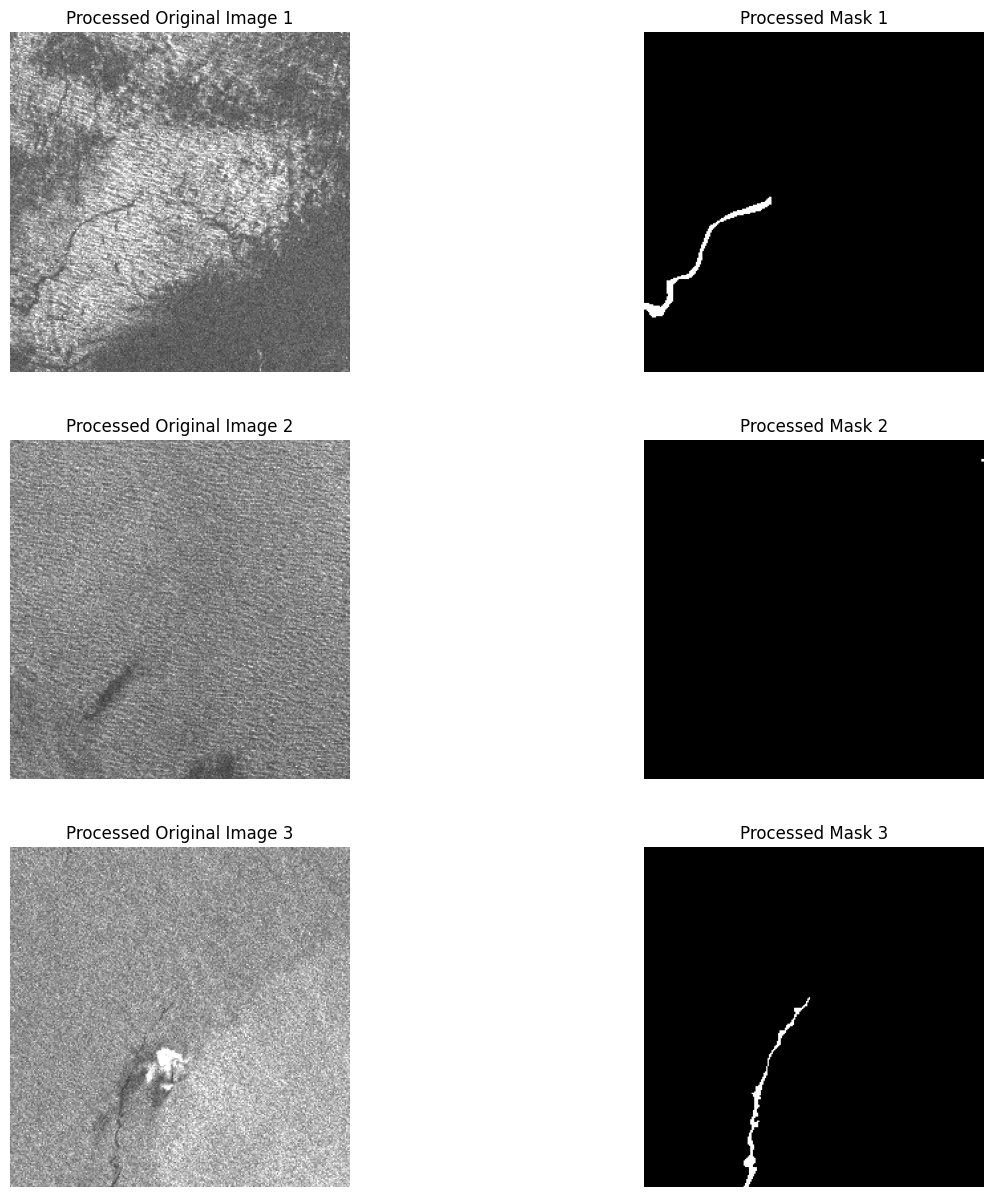

In [ ]:
# Function to visualize a few samples from the dataset
def visualize_samples(X, y, num_samples=3):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        # Display original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        if X[i].shape[-1] == 3:  # Check if the image has 3 channels (RGB)
            plt.imshow(X[i])
        else:  # If not, assume it's a grayscale image and display it accordingly
            plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title(f'Processed Original Image {i+1}')
        plt.axis('off')

        # Display mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title(f'Processed Mask {i+1}')
        plt.axis('off')

    plt.show()

# Visualize some preprocessed samples
visualize_samples(images, masks)


**Creation of training and validation sets**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Validation data shape: {X_val.shape}, {y_val.shape}')


Training data shape: (632, 256, 256, 3), (632, 256, 256, 1)
Validation data shape: (158, 256, 256, 3), (158, 256, 256, 1)


**Data Augmentation for Training Images and Masks**


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

# Data augmentation parameters
data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     fill_mode='constant',
                     cval=0,)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Same seed for image and mask generators
seed = 1

# Fit the generators
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, shuffle=True, seed=seed)

# Combine generators into one
train_generator = zip(image_generator, mask_generator)


 **Validate Data Augmentation**

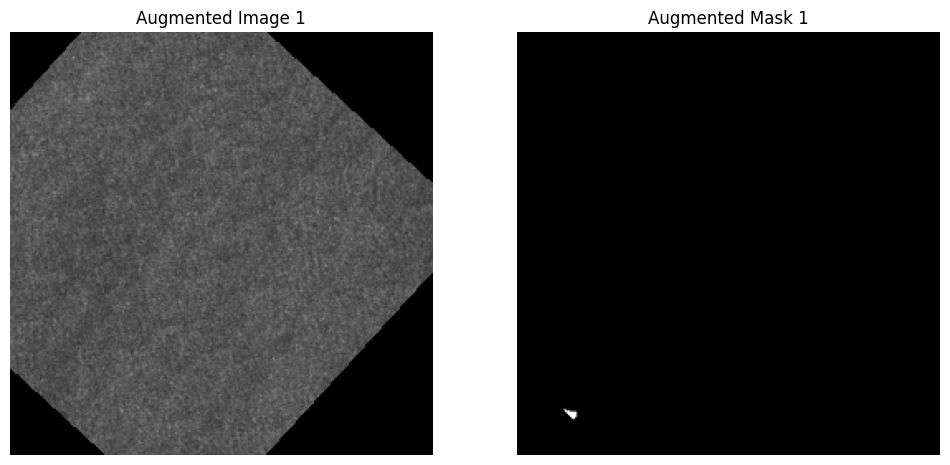

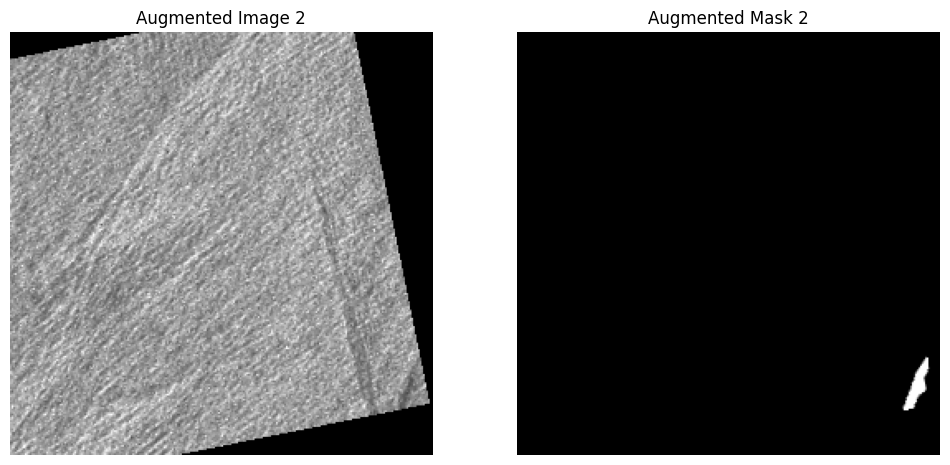

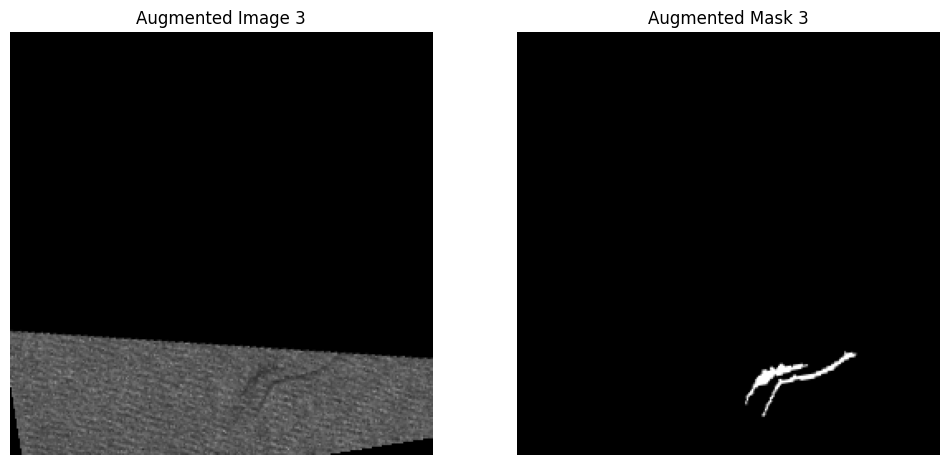

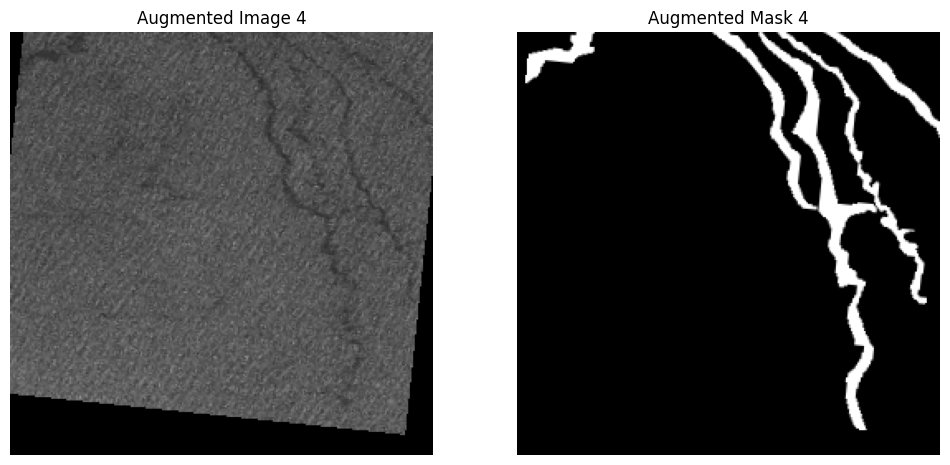

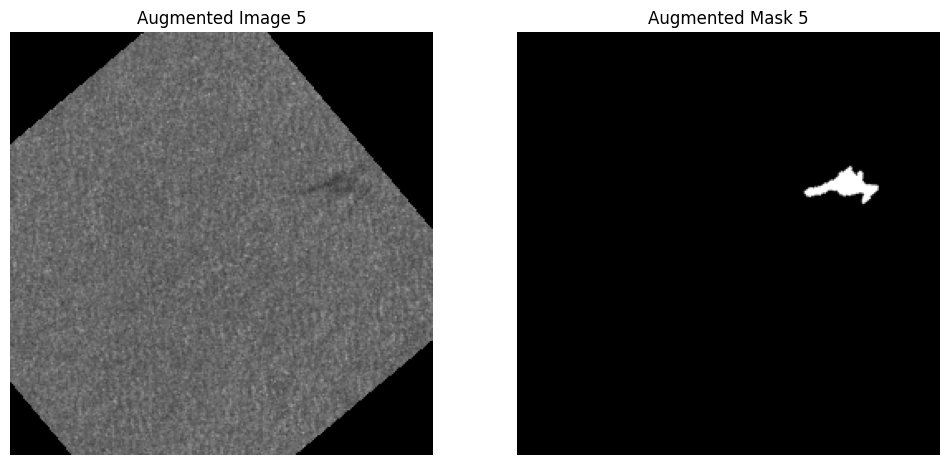

In [ ]:
import matplotlib.pyplot as plt

def plot_image_mask(image, mask, index):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Augmented Image {index}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title(f'Augmented Mask {index}')
    plt.axis('off')

    plt.show()

# Validate preprocessing and augmentation by displaying 5 augmented samples
count = 0
for img, mask in train_generator:
    if count >= 5:
        break
    mask_test = mask[0][:,:,0]
    img_test = img[0]
    plot_image_mask(img_test, mask_test, count+1)
    count += 1


**Custom U-Net Model with Xception Backbone**

I utilised the Xception architecture as the backbone of my custom U-Net model for segmentation tasks. The Xception model, renowned for its efficiency and performance, employs depthwise separable convolutions which reduce computational complexity while maintaining high accuracy. This choice enhances the model's ability to extract detailed features from high-resolution images, making it ideal for my task.

**I incorporated two key types of blocks in my model:**

*Convolution Blocks*: These blocks are crucial for extracting hierarchical features from input images at various levels of abstraction. They help in capturing essential patterns such as edges and textures, which are vital for accurate segmentation.

*Residual Blocks*: These blocks address the vanishing gradient problem, a common issue in deep networks. By allowing gradients to flow directly through the network, residual blocks improve convergence and stability, enabling the training of deeper networks without performance degradation.

In [ ]:
from keras.applications.xception import Xception
from keras.layers import *
from keras.models import *

import tensorflow as tf

# Convolution block with Batch Normalization and optional ReLU activation
def convolution_block(x, filters, size, strides=(1, 1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation:
        x = ReLU()(x)
    return x

# Residual block with two convolution blocks and a skip connection
def residual_block(blockInput, num_filters=16):
    x = ReLU()(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = Add()([x, blockInput])
    return x

# Custom U-Net model with Xception backbone
def custom_unet(input_shape=(256, 256, 3)):
    backbone = Xception(input_shape=input_shape, weights='imagenet', include_top=False)
    input = backbone.input
    start_neurons = 16

    # Encoder: Downsampling path
    conv4 = backbone.layers[121].output
    conv4 = ReLU()(conv4)
    pool4 = AveragePooling2D((2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    # Bottleneck
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm, start_neurons * 32)
    convm = residual_block(convm, start_neurons * 32)
    convm = ReLU()(convm)

    # Decoder: Upsampling path
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.2)(uconv4)

    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4, start_neurons * 16)
    uconv4 = residual_block(uconv4, start_neurons * 16)
    uconv4 = ReLU()(uconv4)

    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.2)(uconv3)

    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3, start_neurons * 8)
    uconv3 = residual_block(uconv3, start_neurons * 8)
    uconv3 = ReLU()(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1, 0), (1, 0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Dropout(0.2)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2, start_neurons * 4)
    uconv2 = residual_block(uconv2, start_neurons * 4)
    uconv2 = ReLU()(uconv2)

    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3, 0), (3, 0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])

    uconv1 = Dropout(0.2)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1, start_neurons * 2)
    uconv1 = residual_block(uconv1, start_neurons * 2)
    uconv1 = ReLU()(uconv1)

    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)
    uconv0 = Dropout(0.2)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0, start_neurons * 1)
    uconv0 = residual_block(uconv0, start_neurons * 1)
    uconv0 = ReLU()(uconv0)

    uconv0 = Dropout(0.2 / 2)(uconv0)
    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv0)

    model = Model(inputs=input, outputs=output_layer, name='custom_unet')

    return model

# Instantiate the custom U-Net model
model = custom_unet(input_shape=(256, 256, 3))

# Print model summary
model.summary()


83683744/83683744 [==============================] - 2s 0us/step
Model: "custom_unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Acti

**Compile the Model with Optimizer and Loss Functions**

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model with a suitable optimizer, loss function, and metrics
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

**Train the Model with Early Stopping and Learning Rate Reduction**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model with data augmentation, early stopping, and learning rate reduction
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    validation_steps=len(X_val) // batch_size,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
39/39 [==============================] - 123s 2s/step - loss: 0.5216 - accuracy: 0.7578 - val_loss: 0.4774 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 29s 755ms/step - loss: 0.3010 - accuracy: 0.9449 - val_loss: 0.2882 - val_accuracy: 0.9815 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 30s 764ms/step - loss: 0.2101 - accuracy: 0.9644 - val_loss: 0.2143 - val_accuracy: 0.9797 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 31s 793ms/step - loss: 0.1596 - accuracy: 0.9664 - val_loss: 0.1996 - val_accuracy: 0.9814 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 30s 778ms/step - loss: 0.1160 - accuracy: 0.9709 - val_loss: 0.1046 - val_accuracy: 0.9812 - lr: 1.0000e-04
Epoch 6/50
39/39 [==============================] - 30s 782ms/step - loss: 0.0826 - accuracy: 0.9706 - val_loss: 0.0402 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 7/50
39/39 [========================

In [ ]:
model.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


*Saving history locally*

In [ ]:
import pickle
with open('model_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

**Visualise Model Performance**

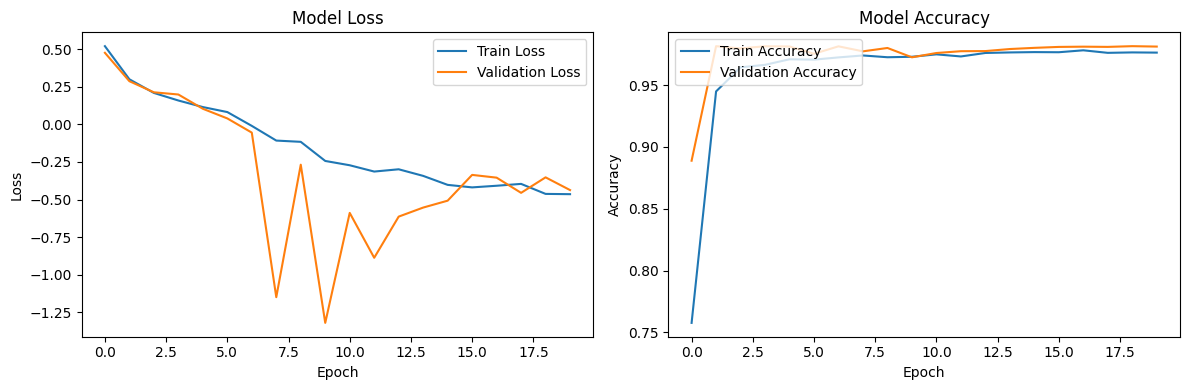

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



**Visualising Model Predictions**

The following visualisation demonstrates the model's performance on a randomly selected image from the dataset. The three panels show the original image, the true mask, and the predicted mask generated by the model.

In [ ]:
import random

# Select a random index from the validation set
random_index = random.randint(0, len(X_val) - 1)

# Get the corresponding image and true mask
random_image = X_val[random_index]
true_mask = y_val[random_index]


In [ ]:
# Run the prediction
predicted_mask = model.predict(np.expand_dims(random_image, axis=0))[0]


1/1 [==============================] - 4s 4s/step


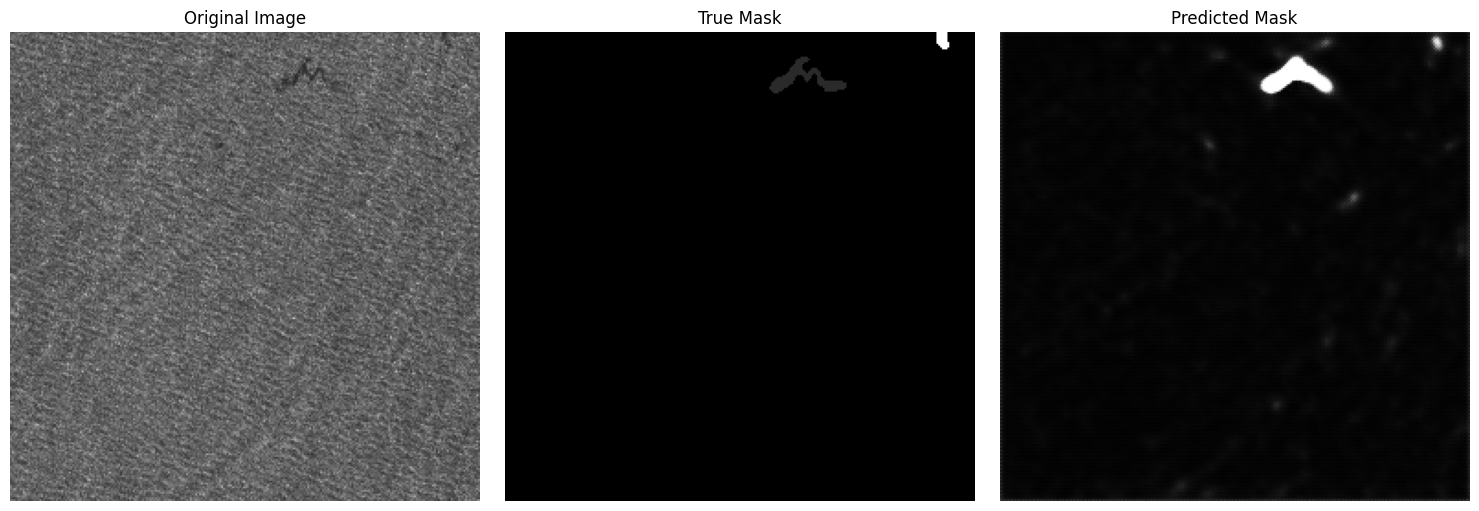

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize the original image, true mask, and predicted mask
def visualize_prediction(image, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Display true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the prediction
visualize_prediction(random_image, true_mask, predicted_mask)


### Conclusion

The evaluation of our model for oil seep detection revealed some critical insights into its performance and areas needing improvement. While the model achieved high accuracy metrics, the overall evaluation indicated that the model was not without its flaws and required further refinement.

#### Training and Validation Metrics
- **Training Loss:** The training loss consistently decreased over the epochs, indicating effective learning from the training data. The steady decline was a positive indicator of the model’s ability to fit the training data well.
- **Validation Loss:** The validation loss showed initial improvement but exhibited fluctuations, suggesting challenges in the model’s ability to generalise to the validation set. These fluctuations were indicative of potential overfitting or inconsistencies in the validation data.

#### Accuracy Metrics
- **Training Accuracy:** The training accuracy increased rapidly and stabilised at a high level, suggesting the model captured the patterns in the training data effectively.
- **Validation Accuracy:** The validation accuracy also reached a high level, stabilising around 97-98%. However, this high accuracy must be interpreted with caution given the fluctuations in validation loss, which indicate that the model’s generalisation capability was not as robust as the accuracy metrics alone might suggest.

#### Visual Evaluation
- **Predicted vs. True Masks:** Visual comparisons of the predicted masks against the true masks showed that the model could identify seep areas, though not always perfectly. The predicted masks often highlighted seep regions but also included false positives, indicating areas where the model needs improvement.

#### Interpretation of Validation Loss Fluctuations
- **Potential Issues:** The fluctuations in validation loss suggest that the model may be overfitting to the training data, performing well on known data but less consistently on unseen data. Noise in the validation dataset could also contribute to these fluctuations.
- **Improvement Strategies:** To address these issues, we could increase regularisation, apply more extensive data augmentation, and fine-tune the learning rate. These strategies aim to stabilise the validation loss and enhance the model’s generalisation capabilities.

### Honest Evaluation and Final Thoughts

While the high accuracy metrics suggest that the model is capable, the fluctuations in validation loss and the visual evaluation indicate that it is not yet fully reliable. The model works reasonably well but requires further refinement to reduce false positives and improve consistency in its predictions.

#### Key Improvements for Future Work:
1. **Increase Epochs:** Allow for more training epochs, using EarlyStopping to ensure thorough learning while preventing overfitting.
2. **Enhanced Data Augmentation:** Incorporate additional augmentation techniques to improve the model’s robustness against variations in the data.
3. **Regularisation Techniques:** Implement L2 regularisation to enhance generalisation and reduce overfitting.
4. **Advanced Learning Rate Scheduling:** Experiment with alternative learning rate schedulers like Cosine Annealing to find an optimal learning rate adjustment strategy.
5. **Model Architecture Enhancements:** Consider deeper layers or attention mechanisms to refine the model’s ability to focus on relevant features, thereby improving segmentation accuracy.
6. **Advanced Optimisation Techniques:** Test advanced optimisers such as RAdam or Lookahead to potentially achieve more stable and improved performance.


In conclusion, while the model demonstrated the potential for oil seep detection with reasonable accuracy, there is significant room for improvement. Addressing the identified issues through systematic experimentation and refinement will enhance the model’s reliability and performance, making it a more robust tool for environmental monitoring and resource management.